<p style="font-size:32px;text-align:center"> <b>Social network Graph Link Prediction - Facebook Challenge</b> </p>

In [1]:
import warnings
warnings.filterwarnings("ignore")

import csv
import pandas as pd
import datetime 
import time 
import numpy as np
import matplotlib
import matplotlib.pylab as plt
import seaborn as sns
from matplotlib import rcParams
from sklearn.cluster import MiniBatchKMeans, KMeans
import math
import pickle
import os
import xgboost as xgb

import warnings
import networkx as nx
import pdb
import pickle
from pandas import HDFStore,DataFrame
from pandas import read_hdf
from scipy.sparse.linalg import svds, eigs
import gc
from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

In [2]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import auc,roc_auc_score
from time import time

In [3]:
from pandas import read_hdf
df_final_train = read_hdf('storage_sample_stage4.h5', 'train_df',mode='r')
df_final_test = read_hdf('storage_sample_stage4.h5', 'test_df',mode='r')

In [4]:
df_final_train.shape

(100002, 59)

In [5]:
df_final_train.columns

Index(['source_node', 'destination_node', 'indicator_link',
       'jaccard_followers', 'jaccard_followees', 'cosine_followers',
       'cosine_followees', 'num_followers_s', 'num_followers_d',
       'num_followees_s', 'num_followees_d', 'inter_followers',
       'inter_followees', 'adar_index', 'follows_back', 'same_comp',
       'shortest_path', 'weight_in', 'weight_out', 'weight_f1', 'weight_f2',
       'weight_f3', 'weight_f4', 'page_rank_s', 'page_rank_d', 'katz_s',
       'katz_d', 'hubs_s', 'hubs_d', 'authorities_s', 'authorities_d',
       'svd_u_s_1', 'svd_u_s_2', 'svd_u_s_3', 'svd_u_s_4', 'svd_u_s_5',
       'svd_u_s_6', 'svd_u_d_1', 'svd_u_d_2', 'svd_u_d_3', 'svd_u_d_4',
       'svd_u_d_5', 'svd_u_d_6', 'svd_v_s_1', 'svd_v_s_2', 'svd_v_s_3',
       'svd_v_s_4', 'svd_v_s_5', 'svd_v_s_6', 'svd_v_d_1', 'svd_v_d_2',
       'svd_v_d_3', 'svd_v_d_4', 'svd_v_d_5', 'svd_v_d_6',
       'pref_attach_followers', 'pref_attach_followees', 'svd_dot_u',
       'svd_dot_v'],
      dtype='o

In [6]:
y_train = df_final_train.indicator_link
y_test = df_final_test.indicator_link

In [7]:
df_final_train.drop(['source_node', 'destination_node','indicator_link'],axis=1,inplace=True)
df_final_test.drop(['source_node', 'destination_node','indicator_link'],axis=1,inplace=True)

In [18]:
params = {
        'learning_rate': 0.1,
        'max_depth': 5,
        'n_estimators' : 1000,
        'min_child_weight':1,
        'subsample':0.9,
        'objective': 'binary:logistic',
        'colsample_bytree':0.9,
        'colsample_bylevel':0.9
         }
start=time()
xgtrain=xgb.DMatrix(data=df_final_train.values,label=y_train.values)
cv_res=xgb.cv(params,xgtrain, num_boost_round=1000, nfold=3,metrics='auc', early_stopping_rounds=20)
clf=xgb.XGBClassifier(**params)
clf.set_params(n_estimators=cv_res.shape[0])

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=0.9,
              colsample_bynode=1, colsample_bytree=0.9, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=709, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.9, verbosity=1)

In [9]:
print(time()-start)

492.22732520103455


In [17]:
Counter(y_train)

Counter({0: 50373, 1: 49629})

In [19]:
clf.get_params()

{'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 0.9,
 'colsample_bynode': 1,
 'colsample_bytree': 0.9,
 'gamma': 0,
 'learning_rate': 0.1,
 'max_delta_step': 0,
 'max_depth': 5,
 'min_child_weight': 1,
 'missing': None,
 'n_estimators': 709,
 'n_jobs': 1,
 'nthread': None,
 'objective': 'binary:logistic',
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'seed': None,
 'silent': None,
 'subsample': 0.9,
 'verbosity': 1}

In [20]:
start=time()
param_tun= {
 'max_depth':[3,5,7,9],
 'min_child_weight':[3,5,7]
}
grid1 = GridSearchCV(estimator =clf,param_grid = param_tun,scoring='roc_auc',cv=3)
grid1.fit(df_final_train,y_train)


GridSearchCV(cv=3, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=0.9, colsample_bynode=1,
                                     colsample_bytree=0.9, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=5, min_child_weight=1,
                                     missing=None, n_estimators=709, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=0.9, verbosity=1),
             iid='deprecated', n_jobs=None,
             param_grid={'max_depth': [3, 5, 7, 9],
                         'min_child_weight': [3, 5, 7]},
             pre_dispatch='2*n_jobs', refit=True, return_train

In [21]:
time()-start

7331.685703754425

In [22]:
grid1.best_params_, grid1.best_score_

({'max_depth': 5, 'min_child_weight': 3}, 0.9991319126720816)

In [23]:
ch_wt=grid1.best_params_['min_child_weight']
dep=grid1.best_params_['max_depth']

In [25]:
params={'min_child_weight':ch_wt,'max_depth':dep}
clf.set_params(**params)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=3, missing=None, n_estimators=709, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.9, verbosity=1)

In [26]:
clf.fit(df_final_train,y_train)
print("AUC score for train data : ",roc_auc_score(y_train,clf.predict(df_final_train)))

AUC score for train data :  0.9990463207579718


In [27]:
#clf.fit(df_final_train,y_train)
y_train_pred=clf.predict(df_final_train)
y_test_pred=clf.predict(df_final_test)

In [28]:
print("AUC score of train data ",roc_auc_score(y_train,y_train_pred))
print("AUC score of test data ",roc_auc_score(y_test,y_test_pred)) 

AUC score of train data  0.9990463207579718
AUC score of test data  0.9112421083804791


In [29]:
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    
    A =(((C.T)/(C.sum(axis=1))).T)
    
    B =(C/C.sum(axis=0))
    plt.figure(figsize=(20,4))
    
    labels = [0,1]
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

Train confusion_matrix


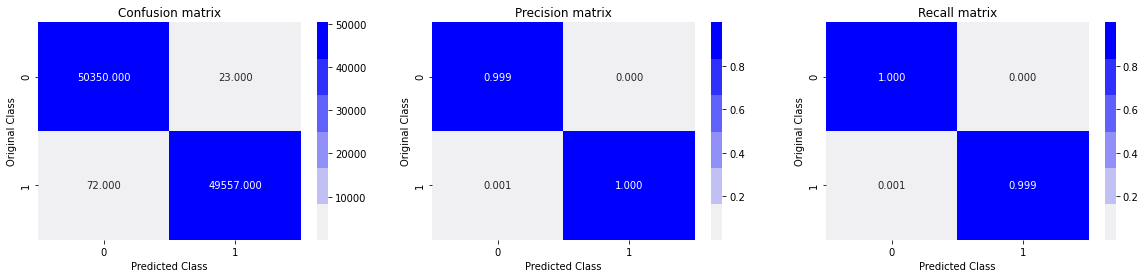

Test confusion_matrix


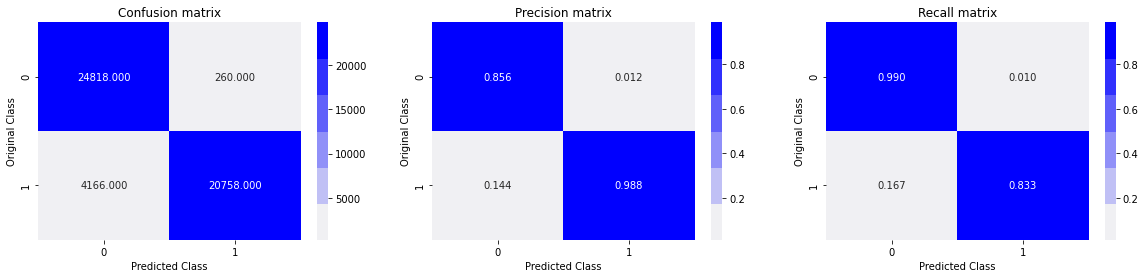

In [30]:
print('Train confusion_matrix')
plot_confusion_matrix(y_train,y_train_pred)
print('Test confusion_matrix')
plot_confusion_matrix(y_test,y_test_pred)

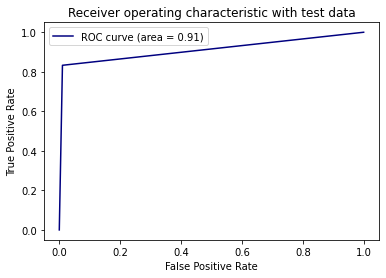

In [31]:
from sklearn.metrics import roc_curve, auc
fpr,tpr,ths = roc_curve(y_test,y_test_pred)
auc_sc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='navy',label='ROC curve (area = %0.2f)' % auc_sc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic with test data')
plt.legend()
plt.show()

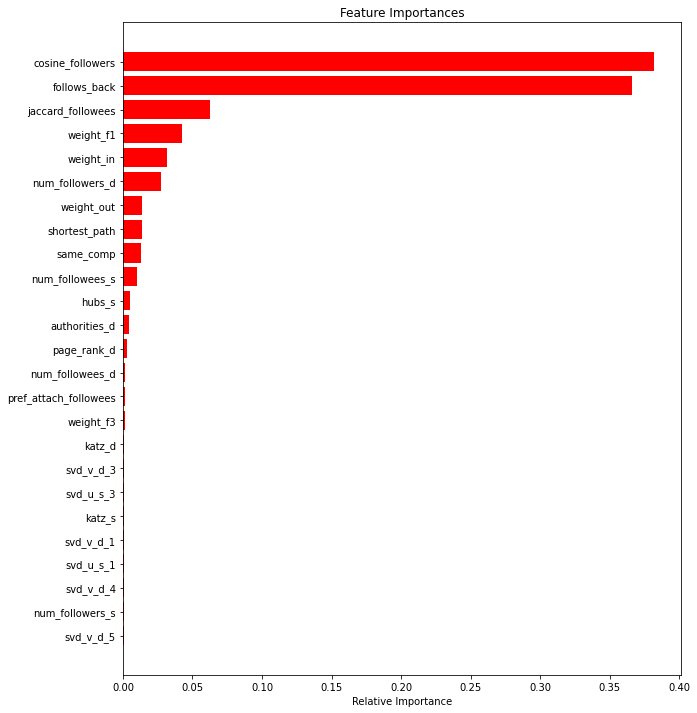

In [32]:
features = df_final_train.columns
importances = clf.feature_importances_
indices = (np.argsort(importances))[-25:]
plt.figure(figsize=(10,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='r', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()